In [55]:
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding
)
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os


In [56]:
csv_path = "dummy_emergency_patients_flexible_5000.csv"  
df = pd.read_csv(csv_path)
df.head()


,patient_id,description,triage_level
0,P00001,Severe persistent trauma noted after a fall.,2
1,P00002,moderate seizure observed during daily activit...,2
2,P00003,mild shortness of breath was triggered by stre...,1
3,P00004,Mild mild sore throat reported with no other s...,4
4,P00005,Severe moderate chest pain noted after a fall.,1


In [57]:
# remove duplicated description
df_unique = df.drop_duplicates(subset="description").reset_index(drop=True)

# stratified split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    df_unique, 
    test_size=0.2, 
    stratify=df_unique["triage_level"], 
    random_state=42
)

# shuffle
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Duplicated description removed and shuffled")


Duplicated description removed and shuffled


In [58]:
# Calculate how many rows were removed due to duplicate descriptions
original_count = len(df)
unique_count = len(df_unique)
removed_count = original_count - unique_count

print(f"📄 Original dataset size: {original_count}")
print(f"✅ After removing duplicates: {unique_count}")
print(f"❌ Number of duplicate descriptions removed: {removed_count}")


📄 Original dataset size: 2500
✅ After removing duplicates: 2500
❌ Number of duplicate descriptions removed: 0


In [59]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

unique_labels = sorted(df_unique["triage_level"].unique())
label2id = {int(lvl): i for i, lvl in enumerate(unique_labels)}
id2label = {i: str(lvl) for lvl, i in label2id.items()}

train_dataset = train_dataset.map(lambda x: {"label": label2id[int(x["triage_level"])]})
test_dataset = test_dataset.map(lambda x: {"label": label2id[int(x["triage_level"])]})


Map: 100%|██████████| 500/500 [00:00<00:00, 21735.97 examples/s]


In [60]:
model_name = "medicalai/ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(
        example["description"],
        padding="max_length",
        truncation=True,
        max_length=64
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    id2label=id2label,
    label2id=label2id
)


c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HYUN\.cache\huggingface\hub\models--medicalai--ClinicalBERT. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as

In [ ]:
# training_args = TrainingArguments(
#     output_dir="./results",
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=5e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=15,
#     weight_decay=0.01,
#     logging_dir="./logs",
# )

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results_no_save",      # Output directory still needed
    save_strategy="no",                  # Do not save checkpoints
    evaluation_strategy="epoch",         # Keep evaluating (optional)
    logging_strategy="epoch",            # Keep logging (optional)
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    weight_decay=0.01,
    logging_dir="./logs_no_save",
    logging_steps=999999
)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    report = classification_report(labels, preds, output_dict=True)
    return {
        "accuracy": report["accuracy"],
        "f1": report["weighted avg"]["f1-score"]
    }

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [62]:
trainer.train()

 10%|█         | 125/1250 [00:14<01:56,  9.62it/s]

{'loss': 1.2738, 'grad_norm': 3.553571939468384, 'learning_rate': 1.8e-05, 'epoch': 1.0}














                                         
                                                  
 10%|█         | 126/1250 [00:15<08:59,  2.08it/s]

{'eval_loss': 0.699650764465332, 'eval_accuracy': 0.688, 'eval_f1': 0.6895169270526077, 'eval_runtime': 1.2, 'eval_samples_per_second': 416.667, 'eval_steps_per_second': 26.667, 'epoch': 1.0}


 20%|██        | 250/1250 [00:32<02:17,  7.27it/s]

{'loss': 0.6297, 'grad_norm': 7.172909259796143, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.0}














                                         
                                                  
 20%|██        | 251/1250 [00:33<08:25,  1.97it/s]

{'eval_loss': 0.52459716796875, 'eval_accuracy': 0.732, 'eval_f1': 0.7323779117114113, 'eval_runtime': 1.199, 'eval_samples_per_second': 417.015, 'eval_steps_per_second': 26.689, 'epoch': 2.0}


 30%|███       | 375/1250 [00:53<02:51,  5.10it/s]

{'loss': 0.513, 'grad_norm': 6.350696563720703, 'learning_rate': 1.4e-05, 'epoch': 3.0}















                                         
                                                  
 30%|███       | 376/1250 [00:55<09:04,  1.61it/s]

{'eval_loss': 0.5278983116149902, 'eval_accuracy': 0.714, 'eval_f1': 0.7106649042450314, 'eval_runtime': 1.434, 'eval_samples_per_second': 348.675, 'eval_steps_per_second': 22.315, 'epoch': 3.0}


 40%|████      | 500/1250 [01:17<02:10,  5.74it/s]

{'loss': 0.4728, 'grad_norm': 4.714306831359863, 'learning_rate': 1.2e-05, 'epoch': 4.0}















                                         
                                                  
 40%|████      | 501/1250 [01:19<07:43,  1.62it/s]

{'eval_loss': 0.47024065256118774, 'eval_accuracy': 0.726, 'eval_f1': 0.7204139915974925, 'eval_runtime': 1.4895, 'eval_samples_per_second': 335.675, 'eval_steps_per_second': 21.483, 'epoch': 4.0}


 50%|█████     | 625/1250 [01:41<01:53,  5.52it/s]

{'loss': 0.4354, 'grad_norm': 6.883225440979004, 'learning_rate': 1e-05, 'epoch': 5.0}















                                         
                                                  
 50%|█████     | 626/1250 [01:43<06:32,  1.59it/s]

{'eval_loss': 0.49173131585121155, 'eval_accuracy': 0.716, 'eval_f1': 0.7113262991657842, 'eval_runtime': 1.49, 'eval_samples_per_second': 335.569, 'eval_steps_per_second': 21.476, 'epoch': 5.0}


 60%|██████    | 750/1250 [02:03<01:24,  5.95it/s]

{'loss': 0.3998, 'grad_norm': 5.282386779785156, 'learning_rate': 8.000000000000001e-06, 'epoch': 6.0}















                                         
                                                  
 60%|██████    | 751/1250 [02:05<05:28,  1.52it/s]

{'eval_loss': 0.5461521148681641, 'eval_accuracy': 0.732, 'eval_f1': 0.7275354840000516, 'eval_runtime': 1.603, 'eval_samples_per_second': 311.915, 'eval_steps_per_second': 19.963, 'epoch': 6.0}


 70%|███████   | 875/1250 [02:27<00:58,  6.36it/s]

{'loss': 0.3776, 'grad_norm': 8.276812553405762, 'learning_rate': 6e-06, 'epoch': 7.0}
















                                         
                                                  
 70%|███████   | 876/1250 [02:28<03:56,  1.58it/s]

{'eval_loss': 0.512397825717926, 'eval_accuracy': 0.73, 'eval_f1': 0.7305681160336147, 'eval_runtime': 1.541, 'eval_samples_per_second': 324.463, 'eval_steps_per_second': 20.766, 'epoch': 7.0}


 80%|████████  | 1000/1250 [02:51<00:45,  5.51it/s]

{'loss': 0.3548, 'grad_norm': 9.009428977966309, 'learning_rate': 4.000000000000001e-06, 'epoch': 8.0}

















                                         
                                                   
 80%|████████  | 1001/1250 [02:52<02:48,  1.48it/s]

{'eval_loss': 0.5279284119606018, 'eval_accuracy': 0.734, 'eval_f1': 0.7347796348742105, 'eval_runtime': 1.624, 'eval_samples_per_second': 307.881, 'eval_steps_per_second': 19.704, 'epoch': 8.0}


 90%|█████████ | 1125/1250 [03:15<00:22,  5.56it/s]

{'loss': 0.3358, 'grad_norm': 3.9282279014587402, 'learning_rate': 2.0000000000000003e-06, 'epoch': 9.0}















                                         
                                                   
 90%|█████████ | 1126/1250 [03:17<01:23,  1.48it/s]

{'eval_loss': 0.5490565299987793, 'eval_accuracy': 0.73, 'eval_f1': 0.7280882328882816, 'eval_runtime': 1.606, 'eval_samples_per_second': 311.333, 'eval_steps_per_second': 19.925, 'epoch': 9.0}


100%|██████████| 1250/1250 [03:39<00:00,  5.88it/s]

{'loss': 0.3202, 'grad_norm': 9.507877349853516, 'learning_rate': 0.0, 'epoch': 10.0}


















                                         
                                                   
100%|██████████| 1250/1250 [03:40<00:00,  5.88it/s]

100%|██████████| 1250/1250 [03:40<00:00,  5.66it/s]

{'eval_loss': 0.5539453029632568, 'eval_accuracy': 0.736, 'eval_f1': 0.7349353207380371, 'eval_runtime': 1.701, 'eval_samples_per_second': 293.945, 'eval_steps_per_second': 18.812, 'epoch': 10.0}
{'train_runtime': 220.7993, 'train_samples_per_second': 90.58, 'train_steps_per_second': 5.661, 'train_loss': 0.5112910949707031, 'epoch': 10.0}


TrainOutput(global_step=1250, training_loss=0.5112910949707031, metrics={'train_runtime': 220.7993, 'train_samples_per_second': 90.58, 'train_steps_per_second': 5.661, 'train_loss': 0.5112910949707031, 'epoch': 10.0})

In [63]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

# Predict
preds_output = trainer.predict(test_dataset)
preds = np.argmax(preds_output.predictions, axis=1)
true = preds_output.label_ids

# Label names
labels = [f"Level {id2label[i]}" for i in range(5)]
report = classification_report(true, preds, target_names=labels, output_dict=True)
cm = confusion_matrix(true, preds)

# Core metrics
accuracy = accuracy_score(true, preds)
precision = precision_score(true, preds, average="macro")
recall = recall_score(true, preds, average="macro")
f1 = report["weighted avg"]["f1-score"]

# ROC-AUC
true_binarized = label_binarize(true, classes=list(range(5)))
preds_binarized = label_binarize(preds, classes=list(range(5)))
roc_auc = roc_auc_score(true_binarized, preds_binarized, average="macro", multi_class="ovr")

# Hyperparameters to record
experiment_config = {
    "model_name": model_name,
    "learning_rate": training_args.learning_rate,
    "train_batch_size": training_args.per_device_train_batch_size,
    "eval_batch_size": training_args.per_device_eval_batch_size,
    "num_epochs": training_args.num_train_epochs
}

# Add all results to JSON
report["overall"] = {
    "accuracy": accuracy,
    "macro_precision": precision,
    "macro_recall": recall,
    "f1_score": f1,
    "roc_auc_macro": roc_auc
}
report["config"] = experiment_config

# Save as JSON
os.makedirs("./output", exist_ok=True)
with open("./output/evaluation_metrics.json", "w") as f:
    json.dump(report, f, indent=4)
print("✅ Saved evaluation_metrics.json")


100%|██████████| 32/32 [00:01<00:00, 22.47it/s]

✅ Saved evaluation_metrics.json


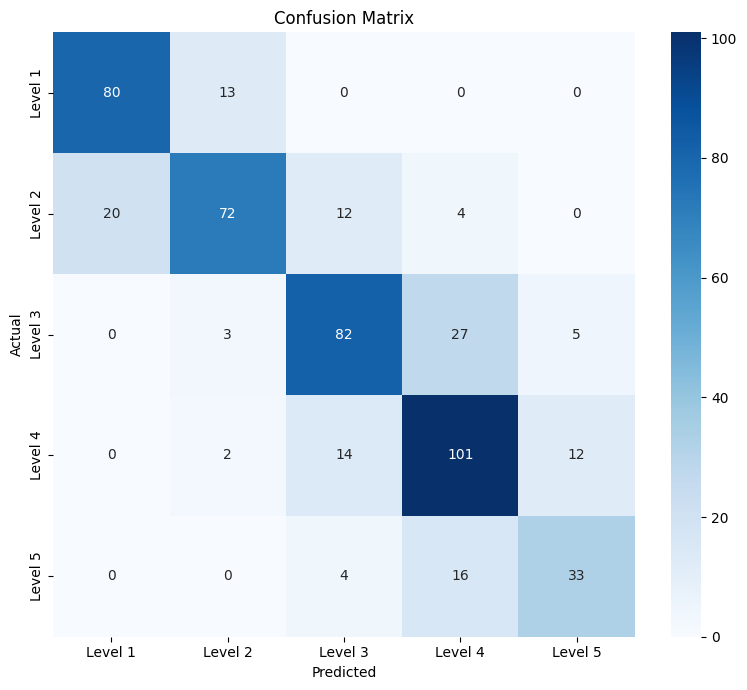

In [64]:
# Plot confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("./output/confusion_matrix.png")
plt.show()

In [65]:
print("\nExperiment Configuration:\n")
for key, value in report["config"].items():
    print(f"{key:>20}: {value}")

print("\nModel Evaluation Summary:\n")
overall = report["overall"]
for metric, value in overall.items():
    print(f"{metric:>20}: {value:.4f}")


Experiment Configuration:

          model_name: medicalai/ClinicalBERT
       learning_rate: 2e-05
    train_batch_size: 16
     eval_batch_size: 16
          num_epochs: 10

Model Evaluation Summary:

            accuracy: 0.7360
     macro_precision: 0.7349
        macro_recall: 0.7267
            f1_score: 0.7349
       roc_auc_macro: 0.8295


In [66]:
# model.save_pretrained("./saved_model")
# tokenizer.save_pretrained("./saved_tokenizer")


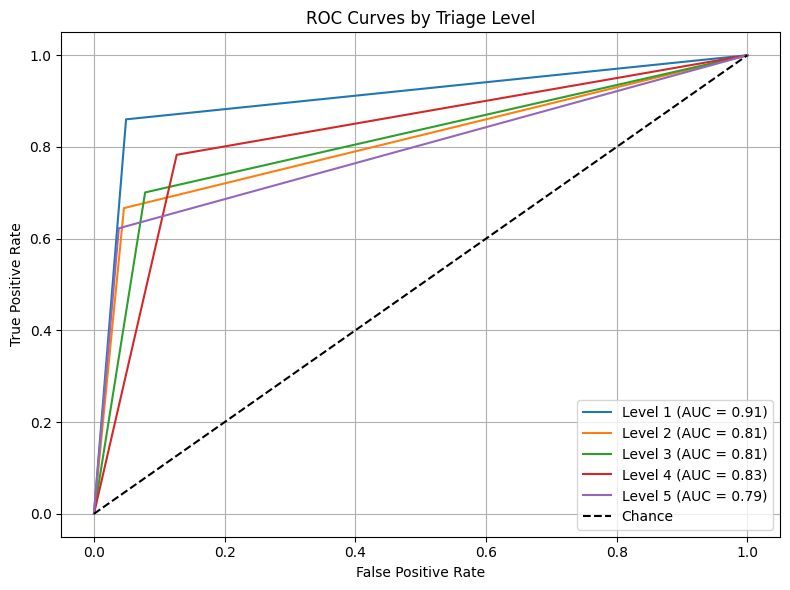

In [67]:
fpr, tpr, roc_auc_curve = {}, {}, {}

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(true_binarized[:, i], preds_binarized[:, i])
    roc_auc_curve[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f"Level {id2label[i]} (AUC = {roc_auc_curve[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.title("ROC Curves by Triage Level")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("./output/roc_curves.png")
plt.show()


In [68]:
intersection = set(train_df['description']).intersection(set(test_df['description']))
print("🚨 amount of duplicated description:", len(intersection))


🚨 amount of duplicated description: 0


📊 Label distribution in training set:
triage_level
1    374
2    434
3    467
4    513
5    212
Name: count, dtype: int64 

📊 Label distribution in test set:
triage_level
1     93
2    108
3    117
4    129
5     53
Name: count, dtype: int64 



100%|██████████| 32/32 [00:00<00:00, 39.55it/s]


📈 Classification Report:

              precision    recall  f1-score   support

     Level 1       0.80      0.86      0.83        93
     Level 2       0.80      0.67      0.73       108
     Level 3       0.73      0.70      0.72       117
     Level 4       0.68      0.78      0.73       129
     Level 5       0.66      0.62      0.64        53

    accuracy                           0.74       500
   macro avg       0.73      0.73      0.73       500
weighted avg       0.74      0.74      0.73       500



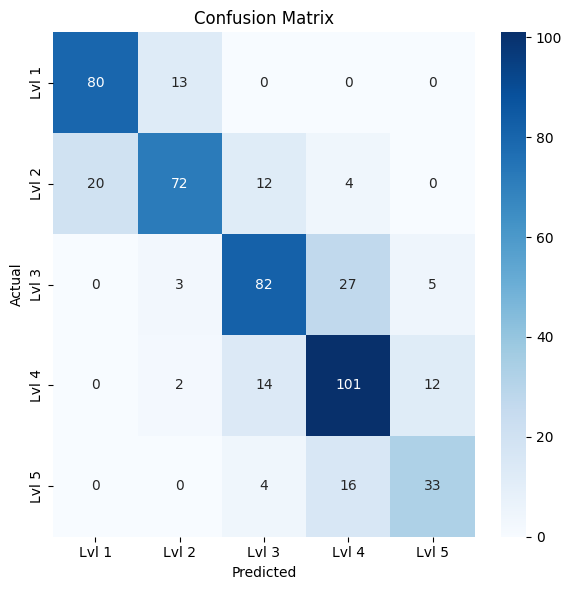


❌ Top 10 Incorrect Predictions:


,description,true_label,predicted_label,confidence
3,Patient reports persistent skin rash after exe...,5,4,3.943090
6,mild nausea occurred with vomiting and nausea.,3,4,3.614080
7,persistent headache was triggered by stress at...,4,3,3.491283
12,intermittent headache started during the night...,4,3,3.673909
15,Complaint of persistent trauma after exposure ...,1,2,3.463779
22,mild abdominal pain and dizziness reported tog...,3,4,3.037801
23,severe trauma following long travel.,2,1,3.273814
24,Symptoms started with moderate nausea and then...,3,4,3.066783
26,mild dizziness has interfered with appetite.,3,4,3.725249
28,severe sore throat has interfered with appetite.,5,4,3.534209



🔍 Avg Confidence per True Class:
label
0    4.317028
1    3.715369
2    3.839927
3    3.708171
4    3.596995
Name: confidence, dtype: float32

🔁 Raw Confusion Matrix:


,Pred_1,Pred_2,Pred_3,Pred_4,Pred_5
True_1,80,13,0,0,0
True_2,20,72,12,4,0
True_3,0,3,82,27,5
True_4,0,2,14,101,12
True_5,0,0,4,16,33


In [69]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Check label distribution in train/test
print("📊 Label distribution in training set:")
print(train_df["triage_level"].value_counts().sort_index(), "\n")

print("📊 Label distribution in test set:")
print(test_df["triage_level"].value_counts().sort_index(), "\n")

# 2. Get predictions and labels
preds_output = trainer.predict(test_dataset)
preds = np.argmax(preds_output.predictions, axis=1)
true = preds_output.label_ids
probs = np.max(preds_output.predictions, axis=1)

# 3. Classification report
print("📈 Classification Report:\n")
print(classification_report(true, preds, target_names=[f"Level {id2label[i]}" for i in range(5)]))

# 4. Confusion matrix
cm = confusion_matrix(true, preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[f"Lvl {id2label[i]}" for i in range(5)],
            yticklabels=[f"Lvl {id2label[i]}" for i in range(5)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 5. Analyze incorrect predictions
wrong_mask = preds != true
wrong_examples = test_df.iloc[wrong_mask]
wrong_examples = wrong_examples.copy()
wrong_examples["true_label"] = [id2label[i] for i in true[wrong_mask]]
wrong_examples["predicted_label"] = [id2label[i] for i in preds[wrong_mask]]
wrong_examples["confidence"] = probs[wrong_mask]

print("\n❌ Top 10 Incorrect Predictions:")
display(wrong_examples[["description", "true_label", "predicted_label", "confidence"]].head(10))

# 6. Average prediction confidence per class
conf_df = pd.DataFrame({"label": true, "pred": preds, "confidence": probs})
print("\n🔍 Avg Confidence per True Class:")
print(conf_df.groupby("label")["confidence"].mean())

# 7. (Optional) Show most confusing class pairs
cm_df = pd.DataFrame(cm, columns=[f"Pred_{id2label[i]}" for i in range(5)],
                        index=[f"True_{id2label[i]}" for i in range(5)])
print("\n🔁 Raw Confusion Matrix:")
display(cm_df)
